# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

### Installing the required libraries

In [40]:
from pydeck import nbextension
import widgetsnbextension
!pip install matplotlib geopandas plotly pygris folium
!pip install jupyterlab_widgets ipywidgets
!pip install openmeteo-requests

In [41]:
!pip install nbformat cartopy seaborn
!pip install certifi

### Importing libraries

In [42]:
import calendar # convert numerical months to month name abbreviations.
import matplotlib.pyplot as plt # to make static plots
import pandas as pd # data loading and manipulation
import geopandas as gpd # to handle the geospatial data
from shapely.geometry import Point, box # GeoPandas includes shapely, which we’ll use to create a geospatially aware GeoDataFrame from the CSV file.
import certifi
import ssl

### Loading Data and Preparing the GeoDataFrame
The NOAA CSV file is stored on a Gist for convenience. We’ll start by loading it as a pandas DataFrame and then filter out the non-contiguous US components.

In [43]:
# Load the CSV file into a DataFrame
df_raw = pd.read_csv('../data/1950-2023_actual_tornadoes.csv')

# Filter out Alaska, Hawaii, Puerto Rico, and Virgin Islands: The tilde (~) in the second line negates the boolean Series. So, we’re telling pandas to give us a DataFrame without the listed states.
df = df_raw[~df_raw['st'].isin(['AK', 'HI', 'PR', 'VI'])]

# Create a GeoDataFrame for the data points
geometry = gpd.array.from_shapely([Point(xy) for xy in zip(df['slon'],
                                                           df['slat'])])
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Filter out rows where magnitude is -9 (unknown):
gdf = gdf[(gdf['mag'] != -9)]

The primary geospatial data in the CSV file is the latitude (slat) and longitude (slon) columns. We’ll use GeoPandas and Shapely to turn these into a geometry column, which is what distinguishes GeoDataFrames from DataFrames. We’ll also assign a coordinate reference system (crs) so GeoPandas knows how to project the data onto a flat map.

The final step filters out tornadoes with no assigned magnitude value (unknown = -9). We do this so that we can work with magnitude values later. This removes about 1,024 tornadoes from the dataset:

In [44]:
# Count the number of occurrences of -9 in the 'mag' column:
num_negative_nines = (df['mag'] == -9).sum()
print(f"Number of -9 values in the 'mag' column: {num_negative_nines}")

Number of -9 values in the 'mag' column: 1024


### Preparing the State Borders

In [45]:
import ssl
import certifi
import urllib.request

# Force use of certifi's cert bundle
ssl_context = ssl.create_default_context(cafile=certifi.where())
opener = urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl_context))
urllib.request.install_opener(opener)


states_gdf = gpd.read_file("data/tl_2020_us_state/tl_2020_us_state.shp")


Next, we use the "STUSPS" column of states_gdf to filter out states and territories not in the Lower 48. Then we use the FIPS state codes in the "STSTEFP" column to filter out the counties in these excluded states from the counties_gdf GeoDataFrame.
A FIPS state code is a numeric code defined in U.S. Federal Information Processing Standard Publication ("FIPS PUB") 5–2 to identify U.S. states and other associated areas. You can find these codes [here](https://www.census.gov/library/reference/code-lists/ansi.html).

In [46]:
print("[Before filtering] Total states: ", states_gdf.shape[0])
# Filter for the contiguous US:
states_gdf = states_gdf[~states_gdf['STUSPS'].isin(['AK', 'HI', 'PR', 'VI'])]

print("[After filtering] Total states: ", states_gdf.shape[0])

[Before filtering] Total states:  56
[After filtering] Total states:  52


The last two steps create a bounding box that encompasses the contiguous US and then uses it to clip the GeoDataFrames. This produces a better-looking map, in my opinion.

In [47]:
# Create a bounding box for the specified map bounds:
bounds_box = box(-127, 23, -67, 50)  # (min_lon, min_lat, max_lon, max_lat)

# Clip the GeoDataFrames to the bounding box:
clipped_states = gpd.clip(states_gdf, bounds_box)

### Plotting the Map
Now we use Matplotlib and GeoPandas to plot the data. While GeoPandas is built on Matplotlib and can plot without it, you get more refined results using Matplotlib.

This code is annotated and straightforward. One thing to note, We are plotting the first reported location of the tornadoes (the "s" in slat and slon stands for "start").
Here’s the result, showing almost 70,000+ tornadoes:

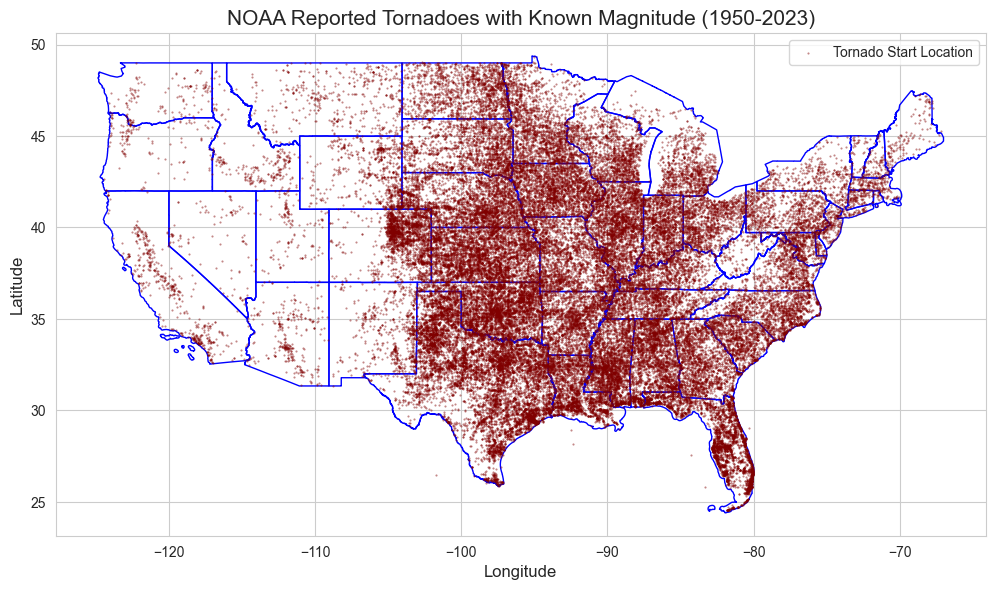

In [48]:
# Function to plot tornadoes for a given period on the US map
def plot_tornadoes_by_period(gdf, start_year, end_year):
    # Plot the filtered data:
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    # Plot the state borders:
    clipped_states.plot(ax=ax,
                        color='none',
                        edgecolor='blue',
                        linewidth=1)

    # Filter data for the specified period
    gdf_period = gdf[(gdf['yr'] >= start_year) & (gdf['yr'] <= end_year)]

    # Plot the tornado locations:
    gdf_period.plot(ax=ax,
             color='maroon',
             marker='.',
             markersize=1,
             alpha=0.5,
             label='Tornado Start Location')

    plt.title(f"NOAA Reported Tornadoes with Known Magnitude ({start_year}-{end_year})",
              fontsize=15)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend()

    plt.show()

# Plot for both periods using the function
plot_tornadoes_by_period(gdf, 1950, 2023)